In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 6s 137ms/step - loss: 0.0282 - val_loss: 0.0024
Epoch 2/100
19/19 [==============================] - 2s 92ms/step - loss: 0.0025 - val_loss: 2.5526e-04
Epoch 3/100
19/19 [==============================] - 2s 98ms/step - loss: 8.7346e-04 - val_loss: 1.4733e-04
Epoch 4/100
19/19 [==============================] - 2s 112ms/step - loss: 6.6790e-04 - val_loss: 2.3879e-04
Epoch 5/100
19/19 [==============================] - 2s 102ms/step - loss: 5.9403e-04 - val_loss: 1.3329e-04
Epoch 6/100
19/19 [==============================] - 2s 98ms/step - loss: 5.7961e-04 - val_loss: 3.3269e-04
Epoch 7/100
19/19 [==============================] - 2s 99ms/step - loss: 5.5341e-04 - val_loss: 1.2406e-04
Epoch 8/100
19/19 [==============================] - 2s 106ms/step - loss: 5.0641e-04 - val_loss: 1.3210e-04
Epoch 9/100
19/19 [==============================] - 2s 91ms/step - loss: 4.8248e-04 - val_loss: 1.1485e-04
Epoch 10/100
19/19 [================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 11ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 24491.001667473465


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99916086305134
Testing MAE: 23915.032407259157


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.23263812065124512], [0.2341548651456833], [0.2359085977077484], [0.23779232800006866], [0.23975707590579987], [0.24177901446819305], [0.24384576082229614], [0.2459503710269928], [0.24808813631534576], [0.2502557933330536], [0.2524506747722626], [0.25467079877853394], [0.2569144070148468], [0.2591802179813385], [0.2614670991897583], [0.2637740969657898], [0.2661004960536957], [0.26844555139541626], [0.27080872654914856], [0.2731894254684448], [0.27558720111846924], [0.27800148725509644], [0.28043195605278015], [0.28287819027900696], [0.2853398025035858], [0.2878163158893585], [0.2903074324131012], [0.2928127348423004], [0.2953319251537323], [0.29786446690559387], [0.30041012167930603], [0.30296844244003296], [0.30553892254829407], [0.3081212341785431], [0.3107149600982666], [0.3133196234703064], [0.31593483686447144], [0.31856009364128113], [0.32119494676589966], [0.3238389790058136], [0.3264915943145752], [0.3291524648666382], [0.33182087540626526], [0.33449649810791016], [0.337178

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[27902.59177845],
       [28041.53300618],
       [28202.18350216],
       [28374.74242721],
       [28554.72296264],
       [28739.94244246],
       [28929.26653555],
       [29122.05914289],
       [29317.88891835],
       [29516.4569227 ],
       [29717.51881745],
       [29920.89305503],
       [30126.41856315],
       [30333.97795016],
       [30543.46747457],
       [30754.79977514],
       [30967.90933095],
       [31182.72789102],
       [31399.20631466],
       [31617.29000109],
       [31836.93799974],
       [32058.09843985],
       [32280.74129102],
       [32504.82833269],
       [32730.32407436],
       [32957.18483541],
       [33185.38331546],
       [33414.88129396],
       [33645.65147052],
       [33877.64470444],
       [34110.83915542],
       [34345.19387287],
       [34580.66244614],
       [34817.2148448 ],
       [35054.81284831],
       [35293.41277604],
       [35532.97913749],
       [35773.465522  ],
       [36014.830979  ],
       [36257.03728793],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(420,)


(320, 1)

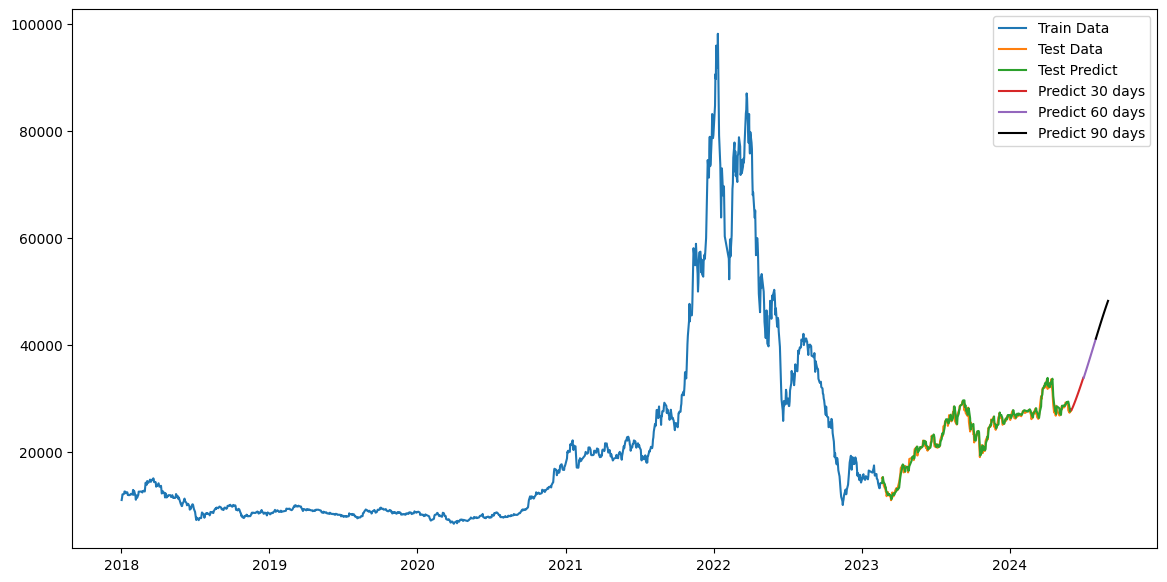

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()